## In this notebook, we will go over some imaging basics.
We will cover the following in order. Note that 1 and 2 are the most important, these actually increase the quality of your data.
1. stacking to improve S/N
2. showing fine details in single band images.
3. Combining to make a color image

In [1]:
# first sort the images into the filters
from astropy.io import fits
import numpy as np
import glob


image_fpaths = glob.glob('/home/gmbrandt/Downloads/M83/*e91*')

fpath_by_filter = {'V': [], 'B': [], 'rp': []}

# lets sort them into filters:
for fpath in image_fpaths:
    hdul = fits.open(fpath)
    filter_name = hdul['SCI'].header['FILTER1']
    fpath_by_filter[filter_name].append(fpath) # place each image of a certain filter into V, B or rp.

for key, fpath_list in fpath_by_filter.items():
    print(f'{len(fpath_list)} images in the {key} filter')

11 images in the V filter
11 images in the B filter
11 images in the rp filter


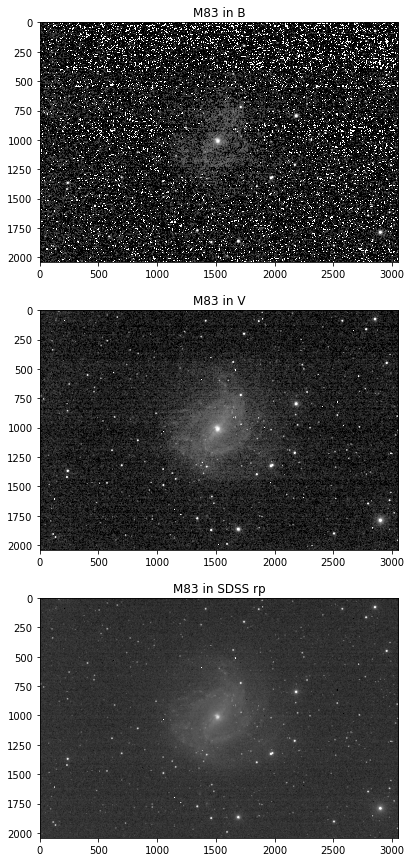

In [7]:
# now lets display one image from each filter.
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# you'll have to mess with vmin vmax to make each image better. Note it will change filter to filter and be
# different for nebulas than galaxies.


im = fits.open(fpath_by_filter['B'][0])['sci'].data
axes[0].imshow(im, norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[0].set_title('M83 in B')

im = fits.open(fpath_by_filter['V'][0])['sci'].data
axes[1].imshow(im, norm=LogNorm(vmin=5, vmax=300), cmap='Greys_r')
axes[1].set_title('M83 in V')

im = fits.open(fpath_by_filter['rp'][0])['sci'].data
axes[2].imshow(im, norm=LogNorm(vmin=5, vmax=5000), cmap='Greys_r') 
axes[2].set_title('M83 in SDSS rp')
plt.show()



General note about vmin and vmax. Lowering vmin will allow fainter features to enter the image. Lowering vmax will make those fainter features appear brighter. Raising vmax will resolve more detail in bright features, but make faint features fainter

A good method is:
   - start with no vmin or vmax, just LogNorm()
   - Set vmax=100000 (100 thousand). Dial vmax down until the faintest features you want are visible
   - set vmin=1. Slowly increase it until the faintest features that you want are visible, and speckles are gone.


We don't really care about the outer extremities of the images (but you might for your science case), so lets zoom in around M83).

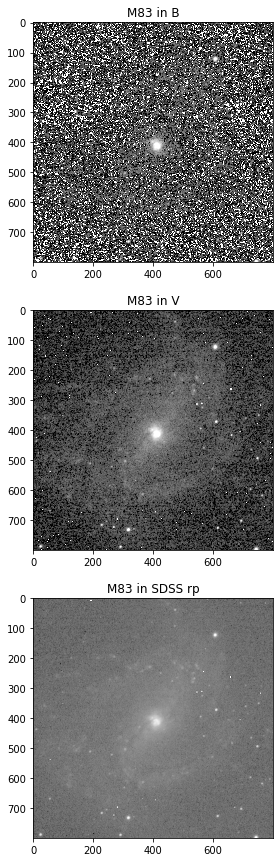

In [6]:
from astropy.nddata import Cutout2D
from astropy import units as u


fig, axes = plt.subplots(3, 1, figsize=(8, 15))

# you'll have to mess with vmin vmax to make each image better. Note it will change filter to filter and be
# different for nebulas than galaxies.

# zoom in on this position in a box of x,y size = size.
position = (1500, 1000)
size = (800, 800)     # pixels
#

im = fits.open(fpath_by_filter['B'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[0].imshow(im, norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[0].set_title('M83 in B')

im = fits.open(fpath_by_filter['V'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[1].imshow(im, norm=LogNorm(vmin=5, vmax=300), cmap='Greys_r')
axes[1].set_title('M83 in V')

im = fits.open(fpath_by_filter['rp'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[2].imshow(im, norm=LogNorm(vmin=10, vmax=600), cmap='Greys_r') 
axes[2].set_title('M83 in SDSS rp')
plt.show()


OK Now lets do whats called median stacking to make the image higher signal to noise.

What we are going to do is stack all of our images together like a sandwich. Like the following:

![](image_stack_visual.png)

Then we are going to take a drill at each pixel, and drill down through each of the images. This will give us an array of length 11 (for 11 images) at each pixel. So we have 3k x 2k "cores". 

Then we take the median of each of those length 11 lists, at each pixel. so something like a million median calculations. Numpy is built to do things like this, so we can actually do it in one blow:

In [8]:
def median_stack(images):
    # note there is also sigma-clipped average stacking, and average stacking. Many ways to do this.
    return np.median(images, axis=0)


def load_cutout_image(index, fpath_by_filter, filter_name, position, size):
    im = fits.open(fpath_by_filter[filter_name][index])['sci'].data
    # cut out to save memory.
    im = Cutout2D(im, position, size).data
    return im

def load_image_stack(fpath_by_filter, filter_name, position, size, num_to_stack):
    images = []
    for i in range(num_to_stack):
        images.append(load_cutout_image(i, fpath_by_filter, filter_name, position, size))
    return images

In [9]:
# Lets start with stacks of 3 images. This will boost our signal to noise by sqrt(3). 

position = (1500, 1000)
size = (800, 800)     # pixels
num_to_stack = 3

stacked_image_by_filter = {'V': None, 'B': None, 'rp': None}

for filter_name in stacked_image_by_filter.keys():
    im_stack = load_image_stack(fpath_by_filter, filter_name, position, size, num_to_stack)
    stacked_image_by_filter[filter_name] = median_stack(im_stack)
    del im_stack # clear the image stack from your memory (freeing up ram)

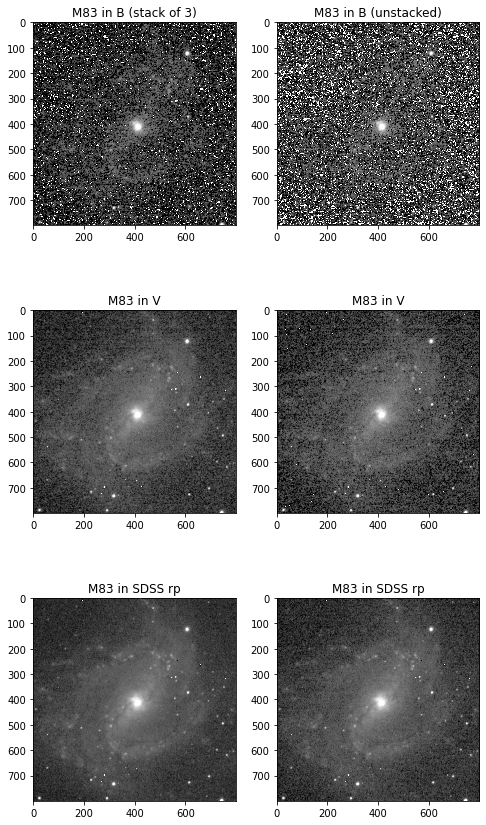

In [10]:

fig, axes = plt.subplots(3, 2, figsize=(8, 15))
axes[0, 0].imshow(stacked_image_by_filter['B'], norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[0, 0].set_title('M83 in B (stack of 3)')

axes[1, 0].imshow(stacked_image_by_filter['V'], norm=LogNorm(vmin=5, vmax=300), cmap='Greys_r')
axes[1, 0].set_title('M83 in V')

axes[2, 0].imshow(stacked_image_by_filter['rp'], norm=LogNorm(vmin=10, vmax=600), cmap='Greys_r') 
axes[2, 0].set_title('M83 in SDSS rp')



im = fits.open(fpath_by_filter['B'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[0, 1].imshow(im, norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[0, 1].set_title('M83 in B (unstacked)')

im = fits.open(fpath_by_filter['V'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[1, 1].imshow(im, norm=LogNorm(vmin=5, vmax=300), cmap='Greys_r')
axes[1, 1].set_title('M83 in V')

im = fits.open(fpath_by_filter['rp'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[2, 1].imshow(im, norm=LogNorm(vmin=10, vmax=600), cmap='Greys_r') 
axes[2, 1].set_title('M83 in SDSS rp')


plt.show()

### The difference is pretty stark right? Just wait till we get to 11 images in a stack. Let's do that now.

In [11]:
num_to_stack = 11

stacked_image_by_filter = {'V': None, 'B': None, 'rp': None}

for filter_name in stacked_image_by_filter.keys():
    im_stack = load_image_stack(fpath_by_filter, filter_name, position, size, num_to_stack)
    stacked_image_by_filter[filter_name] = median_stack(im_stack)
    del im_stack # clear the image stack from your memory (freeing up ram)

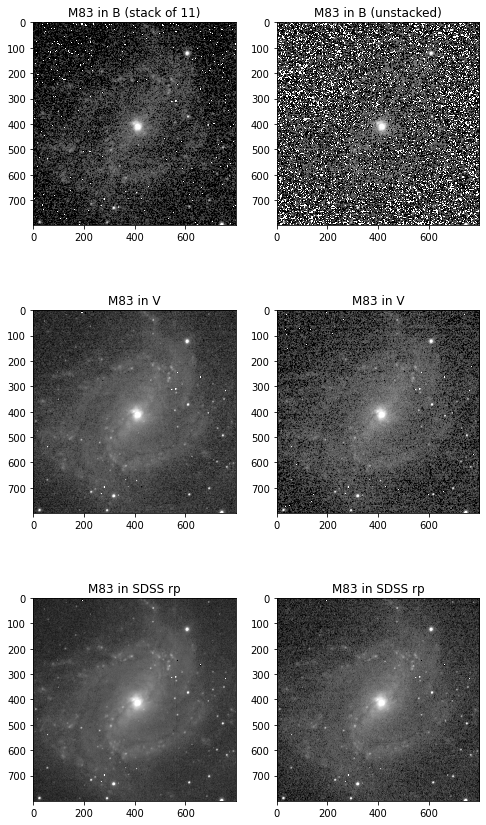

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(8, 15))
axes[0, 0].imshow(stacked_image_by_filter['B'], norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[0, 0].set_title('M83 in B (stack of 11)')

axes[1, 0].imshow(stacked_image_by_filter['V'], norm=LogNorm(vmin=5, vmax=300), cmap='Greys_r')
axes[1, 0].set_title('M83 in V')

axes[2, 0].imshow(stacked_image_by_filter['rp'], norm=LogNorm(vmin=10, vmax=600), cmap='Greys_r') 
axes[2, 0].set_title('M83 in SDSS rp')



im = fits.open(fpath_by_filter['B'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[0, 1].imshow(im, norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[0, 1].set_title('M83 in B (unstacked)')

im = fits.open(fpath_by_filter['V'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[1, 1].imshow(im, norm=LogNorm(vmin=5, vmax=300), cmap='Greys_r')
axes[1, 1].set_title('M83 in V')

im = fits.open(fpath_by_filter['rp'][0])['sci'].data
im = Cutout2D(im, position, size).data
axes[2, 1].imshow(im, norm=LogNorm(vmin=10, vmax=600), cmap='Greys_r') 
axes[2, 1].set_title('M83 in SDSS rp')


plt.show()

## Woah!!! Now you can actually see detail in the B band image.... awesome..

# Part 2: Zooming in details; doing actual science on interesting regions:

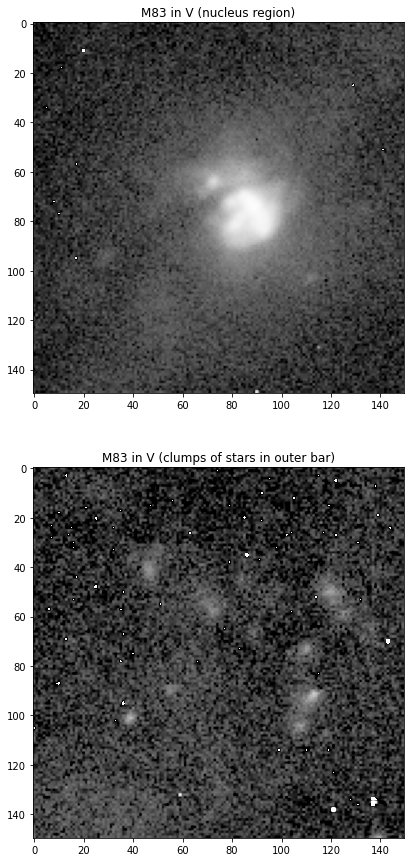

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(8, 15))
im = stacked_image_by_filter['V']
position = (400, 410)
size = (150, 150)
axes[0].imshow(Cutout2D(im, position, size).data, norm=LogNorm(vmax=1000, vmin=10), cmap='Greys_r')
axes[0].set_title('M83 in V (nucleus region)')

position = (500, 250)
axes[1].imshow(Cutout2D(im, position, size).data, norm=LogNorm(vmax=300, vmin=10), cmap='Greys_r')
axes[1].set_title('M83 in V (clumps of stars in outer bar)')
plt.show()

You could for instance, measure the size of the nucleus region.

### Part 3: combining images into a color image.

This part is more artistic than scientific, so lets do some non-kosher things to the image:

- denoise
- sharpen



Text(0.5, 1.0, 'M83 in B (original stack of 11)')

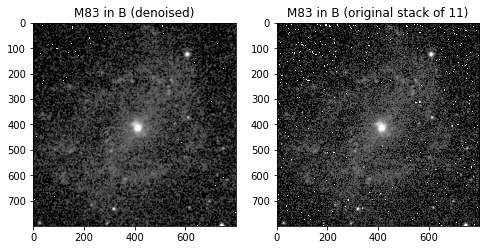

In [14]:
# examples from https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_face_denoise.html
# and https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_sharpen.html

from scipy import ndimage

def denoise(im, kernal_size=3):
    # making the kernal_size larger will slow down the process and make the image blurrier. 
    # play around with the value.
    
    return ndimage.median_filter(im, kernal_size)

def sharpen(im, sharp=3, alpha=30):
    blurred_f = ndimage.gaussian_filter(im, sharp)

    filter_blurred_f = ndimage.gaussian_filter(blurred_f, sharp/3)

    sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
    return sharpened

fig, axes = plt.subplots(1, 2, figsize=(8, 15))
im = stacked_image_by_filter['B']
im = denoise(im, 5)
axes[0].imshow(im, norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[0].set_title('M83 in B (denoised)')


im = stacked_image_by_filter['B']
axes[1].imshow(im, norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
axes[1].set_title('M83 in B (original stack of 11)')

## Now lets make an RGB image

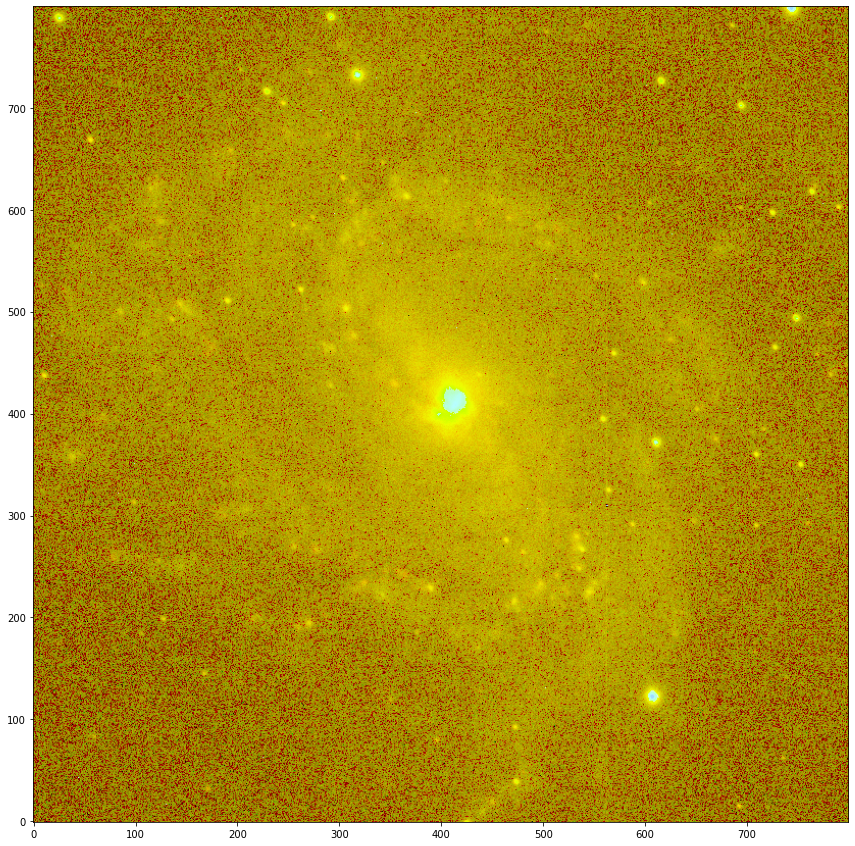

In [22]:
from astropy.visualization import make_lupton_rgb

def log_norm(im, vmin=1, vmax=100000):
    im_copy = 1.*im
    im_copy[im_copy < vmin] = 1
    im_copy[im_copy > vmax] = vmax
    return np.log10(im_copy)

plt.figure(figsize=(15,15))
b, v, rp = stacked_image_by_filter['B'], stacked_image_by_filter['V'], stacked_image_by_filter['rp']
r_scale = 1.0
g_scale = 1.12
b_scale = 1.15
rgb = make_lupton_rgb(log_norm(rp, vmin=2, vmax=100)*r_scale, 
                      log_norm(v, 5, 300)*g_scale, 
                      log_norm(b, 50, 600)*b_scale, 
                      filename="m83.jpeg", Q=1, stretch=2)
plt.imshow(rgb, origin='lower')
plt.show()

In [ ]:
# option 2, export to photo editing software.


In [ ]:

fig, ax = plt.subplots()
ax.imshow(stacked_image_by_filter['B'], norm=LogNorm(vmin=2, vmax=100), cmap='Greys_r')
plt.savefig('/home/gmbrandt/Downloads/B.png', dpi=500)

fig, ax = plt.subplots()
ax.imshow(stacked_image_by_filter['V'], norm=LogNorm(vmin=5, vmax=300), cmap='Greys_r')
plt.savefig('/home/gmbrandt/Downloads/V.png', dpi=500)

fig, ax = plt.subplots()
ax.imshow(stacked_image_by_filter['rp'], norm=LogNorm(vmin=10, vmax=600), cmap='Greys_r') 
plt.savefig('/home/gmbrandt/Downloads/rp.png', dpi=500)